<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Fine-tuning a Large-Language Model</h1>

### Install Required packages
- [PyTorch](https://pytorch.org/get-started/locally/): Deep learning framework.
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/installation): To use pretrained state-of-the-art models.
- [Hugging Face Datasets](https://pypi.org/project/datasets/): Use public Hugging Face datasets
- [IPywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html): For interactive notebook widgets
- [UpTrain](https://github.com/uptrain-ai/uptrain): Use UpTrain to refine, monitor, check for distribution shifts and a whole lot more with your ML models

In [1]:
!pip3 install --upgrade torch accelerate 'transformers[torch]' datasets ipywidgets uptrain nltk tqdm matplotlib==3.6.0 torchview seaborn scikit-learn
!mkdir datasets datasets/raw datasets/cleaned

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘datasets/raw’: File exists
mkdir: cannot create directory ‘datasets/cleaned’: File exists


In [2]:
import matplotlib

# Make sure matplotlib version is >= 3.6 otherwise the plots don't seem to be made as expected
matplotlib.__version__

'3.6.0'

Mount google drive to copy finetuned models and other relevant saved data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp -r /content/drive/MyDrive/uptrain/*.png /content/drive/MyDrive/uptrain/*.json /content/drive/MyDrive/uptrain/*.csv /content/drive/MyDrive/uptrain/*.pickle /content/drive/MyDrive/uptrain/distilbert-base-uncased-finetuned-customer-product-support-v1 /content/drive/MyDrive/uptrain/distilbert-base-uncased-finetuned-customer-product-support-v2 /content/drive/MyDrive/uptrain/datasets .

In [4]:
!cp -r /content/drive/MyDrive/uptrain/* .

Import all the necessary libraries

In [1]:
import collections
import copy
import json
import math
import nltk
import pickle
import random
import string
import torch
import transformers
import uptrain

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from accelerate import Accelerator
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import (
  AutoModelForMaskedLM, AutoTokenizer,
  DataCollatorForLanguageModeling, TrainingArguments, Trainer,
  default_data_collator, get_scheduler, pipeline
)
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchview import draw_graph


transformers.logging.set_verbosity_error()

# Removing imports to work without uploading files to Colab on every
# new instance and instead copying the files as cells

# from model_constants import *
# from model_train import retrain_model
# from helper_funcs import *

### Finetuning distilbert-base-uncased for product and customer support team at Nike

We're going to need nltk's vader_lexicon to perform sentiment analysis to filter out data using UpTrain's EDGE_CASE detection

In [2]:
# Download the vader_lexicon package to use SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Define a few model constants that we will require throughout the notebook

In [3]:
model_checkpoint = "distilbert-base-uncased"
chunk_size = 128
wwm_probability = 0.2
train_size = 0.9
test_size = 0.1
batch_size = 64
mlm_probability = 0.15

train_epochs = 2
model_save_file_name = 'distilbert-base-uncased-finetuned-customer-product-support'

Helper functions provided by UpTrain at the start of the Hackathon.

Brief Overview of what each does:

- `tokenize_function`: Takes in a list of sentences and performs tokenization. The tokenization is done using the BERT Tokenizer. It is done so that the model receives the data in the form it expects it in and was trained on.
- `group_texts`: BERT processes text in chunks of fixed size. Here, we concatenate our inputs and group the in chunks of size `chunk_size`
- `whole_word_masking_data_collator`: Since we're training the model on masked language modelling (i.e. to predict the right words for the masks in sentences), we perform whole word masking using this function. The data collator makes it so that we can process the input tokens in batches.
- `test_model`: Returns the Top 5 predictions made by the model to fill in the masked sentences.
- `create_dataset_from_csv`: Converts a CSV file into JSON file in the way that UpTrain expects data

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels
    return default_data_collator(features)

def test_model(model, text):
    # The original line below doesn't work when using cuda as runtime and
    # PyTorch throws a Runtime Error
    # Setting the inputs device to 'cuda' fixes the issue

    # inputs = tokenizer(text, return_tensors="pt")
    inputs = tokenizer(text, return_tensors="pt").to('cuda')
    
    token_logits = model(**inputs).logits
    # Find the location of [MASK] and extract its logits
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    mask_token_logits = token_logits[0, mask_token_index, :]
    # Pick the [MASK] candidates with the highest logits
    top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
    return [tokenizer.decode([token]) for token in top_5_tokens]

def create_sample_dataset(save_file_name):
    data = {
        "version": "0.1.0",
        "source": "sample",
        "url": "self-generated",
        "data": []
    }
    arr = []
    random_words = ["shoes", "jeans", "tshirts", "sweaters", "pants", "hoodies", "socks", "football"]
    for idx in range(1000):
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Nike " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Adidas " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Puma " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Bata " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
    data["data"] = arr

    with open(save_file_name, 'w') as f:
        json.dump(data, f)
    return save_file_name

def create_dataset_from_csv(file_name, col_name, save_file_name, attrs={}):
  data = pd.read_csv(file_name)
  vals = list(data[col_name])
  r_data = []
  
  for val in vals:
      try:
          val = eval(val)
      except:
          pass
      r_data.append({'text': str(val), 'label': 1})
  
  json_data = attrs
  json_data.update({
      "data": r_data
  })
  
  with open(save_file_name, 'w') as f:
      json.dump(json_data, f)
  
  return save_file_name

Define a CustomCallback that the 🤗 Trainer API calls every time a training step is completed. This is so that we can cache the results between different steps in order to plot results and gather insights from the Trainer history.

In [5]:
class CustomCallback (transformers.TrainerCallback):
  def __init__(self, trainer) -> None:
    super().__init__()
    self._trainer = trainer
    self.outputs = []
    
  def on_step_end(self, args, state, control, **kwargs):
    self.outputs.append(state)
    if control.should_evaluate:
      control_copy = copy.deepcopy(control)
      self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
      return control_copy

Helper functions provided by UpTrain at the start of the hackathon.

I made a few modifications to make it return information I needed while trying things out and make use of the custom callback defined above to cache intermediate states between each step of training.

A brief overview of what the function does is:

- It takes in a dataset that you want the model to finetune on, tokenizes it, batches it and downsamples it
- Creates a trainer for the model using 🤗 Trainer API
- Calculates the perplexity of the model before and after training (how perplexed the model was looking at this data). Perplexity is calculated as the exponential of cross-entropy
- Returns the evaluation results, training results, trainer states accumulated using the custom callback as well as the Trainer itself to be able access its log history.

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def retrain_model(model, dataset, epochs=train_epochs, model_save_file_name=model_save_file_name):
    retrain_dataset = load_dataset('json', data_files={"train": dataset}, field='data')
    tokenized_datasets = retrain_dataset.map(
        tokenize_function, batched=True, remove_columns=["text", "label"]
    )

    lm_datasets = tokenized_datasets.map(group_texts, batched=True)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mlm_probability)

    downsampled_dataset = lm_datasets["train"].train_test_split(
        train_size=train_size, test_size=test_size, seed=42
    )

    # logging_steps = len(downsampled_dataset["train"]) // batch_size
    model_name = model_checkpoint.split("/")[-1]

    training_args = TrainingArguments(
        output_dir=f"{model_name}-finetuned-uptrain",
        overwrite_output_dir=True,
        logging_strategy="steps",
        evaluation_strategy="steps",
        learning_rate=2e-5,
        weight_decay=0.01,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_steps=10,
        eval_steps=2,
        save_steps=10,
        num_train_epochs=epochs
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=downsampled_dataset["train"],
        eval_dataset=downsampled_dataset["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    training_outputs = CustomCallback(trainer)
    trainer.add_callback(training_outputs)

    before_eval_results = trainer.evaluate()
    # print(f">>> Before training, Perplexity: {math.exp(before_eval_results['eval_loss']):.2f}")
    print('Before Training Eval Results:\n', json.dumps(before_eval_results, indent = 2))
    print(f"  Before Training Perplexity: {math.exp(before_eval_results['eval_loss']):.2f}")

    trainer_results = trainer.train()
    trainer.save_model(model_save_file_name)

    after_eval_results = trainer.evaluate()
    # print(f">>> After training, Perplexity: {math.exp(after_eval_results['eval_loss']):.2f}")
    print('After Training Eval Results:\n', json.dumps(after_eval_results, indent = 2))
    print(f"  After Training Perplexity: {math.exp(after_eval_results['eval_loss']):.2f}")

    return (before_eval_results, after_eval_results, trainer_results, training_outputs, trainer)

`top_k_tokens` takes in a masked sentence and uses the model to predict the appropriate words that fit the mask. It takes in a parameter `k` that tells it how many possible alternative words we would like the model to predict and samples them to return the top choices.

In [7]:
def top_k_tokens (model, text, k = 5):
    inputs = tokenizer(text, return_tensors="pt").to('cuda')
    token_logits = model(**inputs).logits
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    mask_token_logits = token_logits[0, mask_token_index, :]
    top_k_tokens = torch.topk(mask_token_logits, k, dim=1).indices[0].tolist()
    return [tokenizer.decode([token]) for token in top_k_tokens]

Define our own set of masked sentences that we would like to test the model on. The first sentence in the list is from the example provided by UpTrain.

For the first sentence, we would like the model to predict positive sentiment words like:

- Comfortable
- Durable
- Good-looking

and to not predict negative sentiment words like:

- Expensive
- Heavy
- Dirty
- Heavy

In [8]:
TOP_K = 10
TESTING_TEXT = [
  "Nike shoes are very [MASK]",
  "Nike atheletic wear is known for being very [MASK]",
  "Nike [MASK] shoes are very comfortable",
  "Trousers and Hoodies made by [MASK] are not very expensive",
  "Nike tshirts are famous for being [MASK]"
]

Let's use the default non-finetuned model to from the 🤗 transformers pipeline to see what predictions it makes for the UpTrain provided example

In [ ]:
unmasker = pipeline('fill-mask', model = model_checkpoint)
print(json.dumps(unmasker(TESTING_TEXT[0]), indent = 2))

[
  {
    "score": 0.2500355839729309,
    "token": 2759,
    "token_str": "popular",
    "sequence": "nike shoes are very popular"
  },
  {
    "score": 0.15420399606227875,
    "token": 25634,
    "token_str": "durable",
    "sequence": "nike shoes are very durable"
  },
  {
    "score": 0.15004488825798035,
    "token": 6450,
    "token_str": "expensive",
    "sequence": "nike shoes are very expensive"
  },
  {
    "score": 0.030206406489014626,
    "token": 6625,
    "token_str": "comfortable",
    "sequence": "nike shoes are very comfortable"
  },
  {
    "score": 0.02582818642258644,
    "token": 19964,
    "token_str": "fashionable",
    "sequence": "nike shoes are very fashionable"
  }
]


As can be seen above, the default model does pretty well. It predicts the words "popular", "durable", "comfortable" and "fashionable" which are pretty great positive sentiment words and is what we expect but it also predicts "expensive". This is the problem that we are trying to solve. We do not want the model to fill in our masks with negative sentiment words unless that is what we explicitly expect.

The below function takes in a `model_name` as parameter and returns the model and tokenizer.

If a GPU is available, it moves the model to it. The model works very slowly when not using a GPU, so if you're running this in Colab, make sure to have a hardware accelerator enabled.

In [9]:
def get_model_and_tokenizer (model_name):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForMaskedLM.from_pretrained(model_name)
  DEVICE = 'cpu'

  print('Is "cuda" available?', torch.cuda.is_available())
  if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))
    DEVICE = 'cuda'

  # Assign to suppress output
  _ = model.to(DEVICE)
  return model, tokenizer

In [ ]:
model, tokenizer = get_model_and_tokenizer(model_checkpoint)

Is "cuda" available? True
Device: Tesla T4


#### Visualizing the model

[Relevant resource](https://github.com/huggingface/transformers/tree/main/examples/research_projects/distillation)

Just for fun, and to understand what the model structure looks like before we start playing around with it, let's see a visual representation.

DistilBERT English language model pretrained on the same data used to pretrain Bert (concatenation of the Toronto Book Corpus and full English Wikipedia) using distillation with the supervision of the bert-base-uncased version of Bert. The model has 6 layers, 768 dimension and 12 heads, totalizing 66M parameters and making it a compact and efficient model for various NLP tasks.

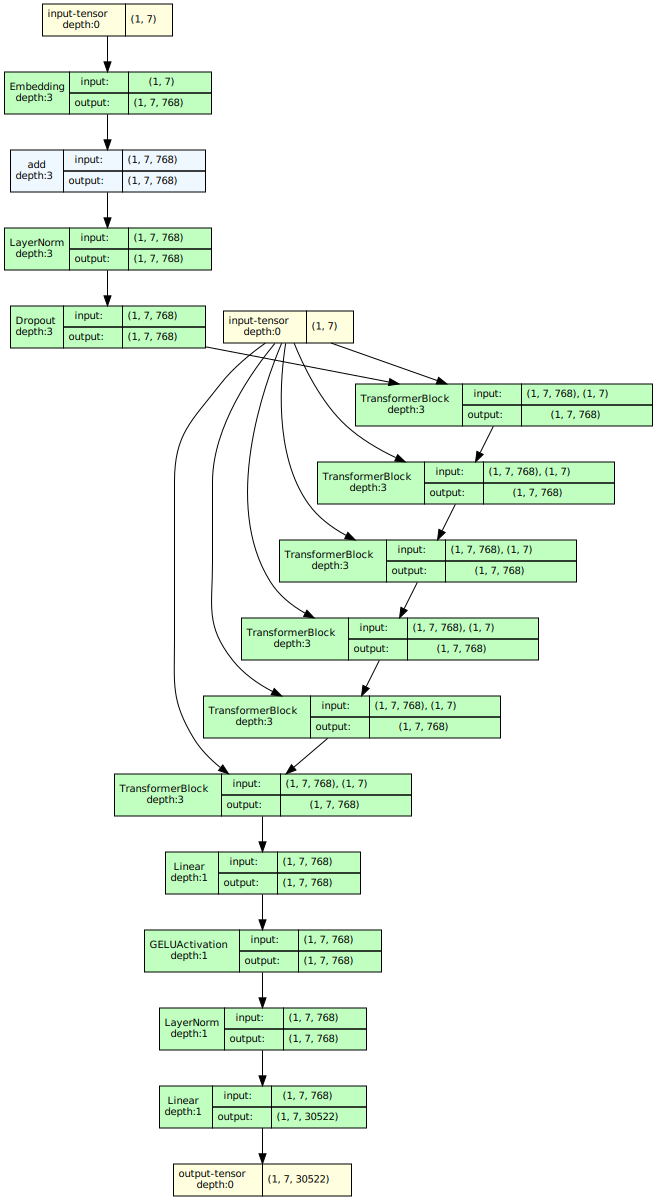

In [ ]:
model_graph = draw_graph(model, input_data=tokenizer(TESTING_TEXT[0], return_tensors="pt").to('cuda'))
model_graph.resize_graph(20)
model_graph.visual_graph

In [ ]:
# We will be generating some data ourselves using the lists below

PRODUCTS = [
    'gym wear', 'jackets', 'shirts',
    'running shoes', 'basketballs', 'caps', 'pants', 'socks',
    'trousers', 'training shoes', 'basketball shoes', 'shoes',
    'athletic wear', 'sports wear', 'footballs',
    'performance gear', 'hats', 'sweaters', 'tshirts', 'wristbands',
    'backpacks', 'tshirts', 'hoodies', 'trainers',
    'soccer shoes',
]

POSITIVE_SENTIMENT_ADJECTIVES = [
    'stylish', 'innovative', 'comfortable', 'durable', 'performance-oriented',
    'high-quality', 'fashionable', 'sporty', 'functional', 'lightweight',
    'breathable', 'flexible', 'athletic', 'modern', 'inexpensive', 'cheap',
    'trendsetting', "revolutionary", 'good-looking', 'versatile', 'efficient',
    'impressive', 'ergonomic', 'sleek', 'user-friendly', 'premium', 'resilient'
]

NEGATIVE_SENTIMENT_ADJECTIVES = [
    'uncomfortable', 'flimsy', 'poor quality', 'outdated', 'unfashionable',
    'heavy', 'inferior', 'unathletic', 'expensive', 'costly',
    'overpriced', 'defective', 'ugly', 'dirty', 'faulty',
    'non-durable', 'tacky', 'lacking in performance', 'clunky', 'bulky',
    'awkward', 'disappointing', 'unreliable', 'displeasing', 'unsatisfactory'
]

ADJECTIVES = POSITIVE_SENTIMENT_ADJECTIVES + NEGATIVE_SENTIMENT_ADJECTIVES

PRODUCT_FEATURE_WORDS = list(set(
  ['comfort', 'fit', 'quality', 'style', 'durability', 'performance', 'design', 'look', 'support', 'flexibility', 'lightweight', 'breathability', 'cushioning', 'grip', 'stability', 'traction', 'bounce'] +
  POSITIVE_SENTIMENT_ADJECTIVES
))

COMPANIES = [
  # repeat a couple of times for higher positive examples of Nike
  'nike', 'nike', 'nike', 'nike', 'nike', 'nike', 'nike'
  'adidas', 'puma', 'under armour', 'new balance', 'reebok',
  'converse', 'vans', 'fila', 'asics'
]

JOINERS = [
  'are', 'is', 'offer', 'provide', 'feature', 'boast',
  'are known for being', 'are recognized for being', 'are famous for being',
  'are renowned for being', 'are praised for being',
]

Some more helper functions

- `csv2json`: Reads a CSV file, converts into JSON format and saves it in another file
- `create_basic_brute_dataset`: Synthesizes a dataset of sentences in hardcoded formats.
    - Many more sentence types are possible and this could be improved but for now, I will have to leave it this way due to lack of time and because of starting the hackathon late.

In [ ]:
def csv2json (csv_file_name, json_file_name, attrs={}):
    df = pd.read_csv(csv_file_name)
    data = []
  
    for _, row in df.iterrows():
        print(row.to_dict())
        data.append({
        'text': row['text'],
        'label': row['label']
        })
  
    json_data = attrs
    json_data.update({'data': data})

    with open(json_file_name, 'w') as f:
        json.dump(json_data, f)

def create_basic_brute_dataset(dataset_size):
    data = {
        "version": "0.1.0",
        "source": "sample",
        "url": "self-generated",
        "data": []
    }
    arr = []

    for idx in range(dataset_size):
        company = random.choice(COMPANIES)
        joiner = random.choice(JOINERS)
        product = random.choice(PRODUCTS)
        label = random.choice([0, 1])

        if label == 0:
            adjective = random.choice(NEGATIVE_SENTIMENT_ADJECTIVES)
        else:
            adjective = random.choice(POSITIVE_SENTIMENT_ADJECTIVES)

        # TODO: expand on the list of possible sentences
        if random.randint(0, 1) == 0:
            sentence = f'{company} {product} {joiner} {adjective}'
        else:
            sentence = f'{product} made by {company} {joiner} {adjective}'

        arr.append({
            "text": sentence,
            "label": label
        })
  
    data["data"] = arr
    return data

def save_dataset (dataset, save_file_name):
    with open(save_file_name, 'w') as f:
        json.dump(dataset, f)

#### Creating a large Dataset for finetuning

I make use of three publicly available datasets related to products and customer support that are relevant to this task. I also synthesize a lot of data by creating sentences in a pre-specified format. For the task of mask filling as expected in the problem statement, this seems to work pretty well but there's a lot of room for improvement.

In [ ]:
SYNTHESIZED_DATASET_SIZE = 25000
uptrain_save_fold_name = "uptrain_smart_data_bert"
synthesized_data_csv = 'data.csv'
synthesized_data_file_name = 'data.json'

nike_products_dataset = {
  'version': "1.0.0",
  'source': "Product Data from Nike",
  'url': "https://data.world/data-hut/product-data-from-nike",
  'infile': "datasets/raw/nike_products.csv",
  'outfile': "datasets/cleaned/nike_products.json"
}

nike_customer_reviews_kaggle_dataset = {
  'version': "1.0.0",
  'source': "Nike Onlinestore Customer Reviews",
  'url': "https://www.kaggle.com/datasets/tinkuzp23/nike-onlinestore-customer-reviews",
  'infile': "datasets/raw/nike_customer_reviews_kaggle.csv",
  'outfile': "datasets/cleaned/nike_customer_reviews_kaggle.json"
}

products_kaggle_dataset = {
  'version': "1.0.0",
  'source': "Products: Prices, Descriptions, Reviews",
  'url': "https://www.kaggle.com/datasets/thedevastator/nike-usa-products-prices-descriptions-and-custom",
  'infile': "datasets/raw/products_kaggle.csv",
  'outfile': "datasets/cleaned/products_kaggle.json"
}

Combining all the datasets into a single one, and performing some basic data cleaning for the datasets collected online.

In [ ]:
df = pd.DataFrame()

# Use the nike_products dataset and append it to our dataframe
nike_products_df = pd.read_csv(nike_products_dataset['infile'])
x = pd.DataFrame()
x['text'] = nike_products_df['Product Name'] + ' ' + nike_products_df['Description']
x.reset_index(drop=True, inplace=True)
x.to_json(nike_products_dataset['outfile'])
df = x

# Use the nike_customer_reviews dataset and append it to our dataframe
nike_customer_reviews_kaggle_df = pd.read_csv(nike_customer_reviews_kaggle_dataset['infile'])
x = pd.DataFrame()
x['text'] = nike_customer_reviews_kaggle_df['Title'] + ' ' + nike_customer_reviews_kaggle_df['Content']
x.reset_index(drop=True, inplace=True)
x.to_json(nike_customer_reviews_kaggle_dataset['outfile'])
df = df.append(x)

# Use the products_kaggle dataset and append it to our dataframe
products_kaggle_df = pd.read_csv(products_kaggle_dataset['infile'])
x = pd.DataFrame()
x['text'] = products_kaggle_df['name'] + ' ' + products_kaggle_df['description']
x.reset_index(drop=True, inplace=True)
x.to_json(products_kaggle_dataset['outfile'])
df = df.append(x)

df = df[df['text'].notna()]

# Replace all raw digits because they're most likely of no use in determining
# masked words
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.digits)))

# Remove all punctuation explicitly even though BERT probably does it
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Create our own dataset of reviews for different companies, products, etc.
brute_dataset = create_basic_brute_dataset(SYNTHESIZED_DATASET_SIZE)
brute_df = pd.DataFrame(brute_dataset['data'])
df = df.append(brute_df)

# Make everything lowercase since the model is uncased
df['text'] = df['text'].str.lower()

print(f'Dataset size: {len(df)}')
print(df)

df.reset_index(drop=True, inplace=True)
df.to_csv(synthesized_data_csv)
create_dataset_from_csv(synthesized_data_csv, 'text', synthesized_data_file_name)

with open(synthesized_data_file_name) as file:
  dataset = json.loads(file.read())

Dataset size: 25946
                                                    text  label
0      nike air force   essential let your shoe game ...    NaN
1      nike air force   the legend lives on in the ni...    NaN
2      nike air force  sage low lx taking both height...    NaN
3      nike air max dia se designed for a womans foot...    NaN
4      nike air max verona pass on the good vibes in ...    NaN
...                                                  ...    ...
24995                     nikeadidas shirts are athletic    1.0
24996            converse shoes are known for being ugly    0.0
24997             new balance training shoes offer heavy    0.0
24998                     fila shirts boast trendsetting    1.0
24999  nike basketball shoes are famous for being com...    1.0

[25946 rows x 2 columns]


More helper functions.

- `perform_training_and_testing`: Takes in a model and trains it on the dataset for some number of epochs. Also evaluates the model on some basic testing masked sentences that were defined above to check if the top tokens predicted by the model are actually improving in the direction we expect it.
- `perform_testing`: Same as above except the training part. Evaluates the model on some testing masked sentences defined above and returns the top tokens that it thinks should fill in the masks.

In [ ]:
def perform_training_and_testing (model, model_save_file_name, data_file_name, epochs):
  original_model_outputs = []
  retrained_model_outputs = []

  for text in TESTING_TEXT:
    original_model_outputs.append({
      'text': text,
      'tokens': top_k_tokens(model, text, TOP_K)
    })

  retrained_data = retrain_model(model, data_file_name, epochs, model_save_file_name)

  for text in TESTING_TEXT:
    retrained_model_outputs.append({
      'text': text,
      'tokens': top_k_tokens(model, text, TOP_K)
    })
  
  return original_model_outputs, retrained_model_outputs, retrained_data

def perform_testing (model):
  outputs = []

  for text in TESTING_TEXT:
    outputs.append({
      'text': text,
      'tokens': top_k_tokens(model, text, TOP_K)
    })
  
  return outputs

def pretty_print_outputs (outputs):
  for x in outputs:
    print('      Text:', x['text'])
    print('Top Tokens:', x['tokens'])

def pretty_print_original_vs_retrained_outputs (original_model_outputs, retrained_model_outputs):
  for original, retrained in zip(original_model_outputs, retrained_model_outputs):
    print('                Text:', original['text'])
    print(' Original Top Tokens:', original['tokens'])
    print('Retrained Top Tokens:', retrained['tokens'])
    print()

#### Training the model on the entire dataset

Here, I train the model on the entire combined dataset that was created above. From the output (that can be found at the very bottom of the output cell), we notice that the model is slightly better and has more positive sentiment overall but still predicts words like "expensive", which is not what we want.

Here's the outputs for the testing masked sentences that we defined above:

```
                Text: Nike shoes are very [MASK]
 Original Top Tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']
Retrained Top Tokens: ['comfortable', 'expensive', 'fashionable', 'durable', 'uncomfortable', 'flexible', 'athletic', 'costly', 'popular', 'heavy']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top Tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare', 'sharp', 'strong', 'distinctive', 'elastic', 'attractive']
Retrained Top Tokens: ['flexible', 'durable', 'expensive', 'fashionable', 'heavy', 'costly', 'lightweight', 'athletic', 'innovative', 'uncomfortable']

                Text: Nike [MASK] shoes are very comfortable
 Original Top Tokens: ['polo', 'golf', 'swim', 'tennis', 'nike', 'shoe', 'sports', 'basketball', 'athletic', 'skate']
Retrained Top Tokens: ['basketball', 'training', 'running', 'soccer', 'football', 'athletic', 'gym', 'performance', 'tennis', 'sports']

                Text: Trousers and Hoodies made by [MASK] are not very expensive
 Original Top Tokens: ['women', 'manufacturers', 'men', 'amateurs', 'slaves', 'consumers', 'collectors', 'europeans', 'farmers', 'artisans']
Retrained Top Tokens: ['men', 'women', 'consumers', 'collectors', 'nike', 'manufacturers', 'people', 'hand', 'amateurs', 'individuals']

                Text: Nike tshirts are famous for being [MASK]
 Original Top Tokens: ['.', ':', ';', 'colorful', 'unique', '!', 'famous', 'tall', 'popular', 'green']
Retrained Top Tokens: ['lightweight', 'inexpensive', 'ugly', 'flexible', 'uncomfortable', 'innovative', 'durable', 'athletic', 'costly', 'dirty']
```

An interesting case to look at is:

```
                Text: Nike tshirts are famous for being [MASK]
 Original Top Tokens: ['.', ':', ';', 'colorful', 'unique', '!', 'famous', 'tall', 'popular', 'green']
Retrained Top Tokens: ['lightweight', 'inexpensive', 'ugly', 'flexible', 'uncomfortable', 'innovative', 'durable', 'athletic', 'costly', 'dirty']

```

Oh, and we also no longer have swimming shoes as was in example 3.

Clearly, the retrained model is doing much better at predicting words in the way we expect it!

This version of the finetuned model is save in the `distilbert-base-uncased-finetuned-customer-product-support-v1` folder. The results of the training are saved in `trainer_v1.pickle` so that we can analyze it in the future too.

In [ ]:
model, tokenizer = get_model_and_tokenizer(model_checkpoint)

original_model_outputs, retrained_model_outputs, results_v1 = \
  perform_training_and_testing(model, model_save_file_name + '-v1', synthesized_data_file_name, epochs=5)

pretty_print_original_vs_retrained_outputs(original_model_outputs, retrained_model_outputs)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Is "cuda" available? True
Device: Tesla T4


  0%|          | 0/1 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 232
  Batch size = 64
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The following columns in the training set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2079
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 165
  Number of trainable parameters = 66985530


Before Training Eval Results:
 {
  "eval_loss": 4.579567909240723,
  "eval_runtime": 1.2697,
  "eval_samples_per_second": 182.718,
  "eval_steps_per_second": 3.15
}
  Before Training Perplexity: 97.47


Step,Training Loss,Validation Loss
2,No log,3.709193
2,No log,3.736752
4,No log,3.220778
4,No log,3.333699
6,No log,2.936335
6,No log,2.973198
8,No log,2.719621
8,No log,2.693990
10,No log,2.531219
10,3.475800,2.545294


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2079
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 232
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2079
  Batch size = 64
The following columns in the evaluatio

After Training Eval Results:
 {
  "eval_loss": 1.4413923025131226,
  "eval_runtime": 1.2658,
  "eval_samples_per_second": 183.281,
  "eval_steps_per_second": 3.16,
  "epoch": 5.0
}
  After Training Perplexity: 4.23
                Text: Nike shoes are very [MASK]
 Original Top Tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']
Retrained Top Tokens: ['comfortable', 'expensive', 'fashionable', 'durable', 'uncomfortable', 'flexible', 'athletic', 'costly', 'popular', 'heavy']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top Tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare', 'sharp', 'strong', 'distinctive', 'elastic', 'attractive']
Retrained Top Tokens: ['flexible', 'durable', 'expensive', 'fashionable', 'heavy', 'costly', 'lightweight', 'athletic', 'innovative', 'uncomfortable']

                Text: Nike [MASK] shoes are very comfortable
 Original T

We see that the model finetuned on the entire dataset is starting to much better in general on our basic testing examples, but let's see if we can do better by making use of UpTrain to detect edge cases for us in an easy way.

The helper functions below are used in the filtering and detection process by UpTrain.

- `nike_text_present_func`: Checks if the word `nike` is present in a sentence
- `nike_product_keyword_func`: Checks if the product is made by Nike
- `is_positive_sentiment_func`: Checks if the sentence has positive sentiment
- `content_length_func`: Used to check if the sentence length provided to BERT is not larger that the maximum tokens that it can accept

In [ ]:
vader_sia = SentimentIntensityAnalyzer()

def nike_text_present_func (inputs, outputs, gts=None, extra_args={}):
  is_present = []
  for input in inputs["text"]:
    is_present.append(bool("nike" in input.lower()))
  return is_present

def nike_product_keyword_func (inputs, outputs, gts=None, extra_args={}):
  is_present = []
  for input in inputs["text"]:
    input = input.lower()
    for word in PRODUCTS:
      if word in input:
        is_present.append(True)
        break
    else:
      is_present.append(False)
  return is_present

def is_positive_sentiment_func (inputs, outputs, gts=None, extra_args={}):
  is_positive = []
  for input in inputs["text"]:
    input = input.lower()
    positive = False
    
    if vader_sia.polarity_scores(input)["compound"] >= 0:
      for word in PRODUCT_FEATURE_WORDS:
        if word in input:
          positive = True
          break
    
    is_positive.append(positive)
  
  return is_positive

def content_length_func (inputs, outputs, gts=None, extra_args={}):
  lengths = []
  for input in inputs["text"]:
    lengths.append(len(input))
  return lengths

Initializing and configuring the UpTrain framework

In [ ]:
# I have no idea what some cfg checks do due to poor documentation
# From what I could understand through the examples provided by UpTrain, and because
# of slight boost in lowering of perplexity of finetuned model, this is the final
# config that I settled on

cfg = {
    'checks': [
        {
            'type': uptrain.Anomaly.EDGE_CASE,
            "signal_formulae": \
                uptrain.Signal("'Nike' text Present", nike_text_present_func) &
                uptrain.Signal("Is it a Nike product", nike_product_keyword_func) &
                uptrain.Signal("Is positive Sentiment", is_positive_sentiment_func)
        },

        {
            'type': uptrain.Anomaly.DATA_INTEGRITY,
            'measurable_args': {
                'type': uptrain.MeasurableType.INPUT_FEATURE,
                'feature_name': 'text'
            },
            'integrity_type': 'non_null'
        },

        {
            'type': uptrain.Anomaly.DATA_INTEGRITY,
            'measurable_args': {
                'type': uptrain.MeasurableType.CUSTOM,
                'signal_formulae': uptrain.Signal("content_length", content_length_func),
            },
            "integrity_type": "greater_than",
            "threshold": 256
        },

        {
            'type': uptrain.Anomaly.CONCEPT_DRIFT,
            'algorithm': uptrain.DataDriftAlgo.DDM
        }
    ],

    # Define where to save the retraining dataset
    'retraining_folder': uptrain_save_fold_name,
    
    # Define when to retrain, define a large number because we
    # are not retraining yet
    'retrain_after': 10000000000
}

framework = uptrain.Framework(cfg)

Deleting the folder:  uptrain_smart_data_bert


Creating a Retraining dataset using the UpTrain framework based on the configuration defined above.

The framework creates retraining examples as a CSV file. We then convert into JSON format to put it in the way `retrain_model` expects it.

We can see that UpTrain processes our entire dataset of about 26000 samples and detects about 7000 edge cases. All this new data ends up in the `retrain_dataset.json` file.

In [ ]:
for index, sample in enumerate(dataset['data']):
  if index % 500 == 0:
    print(f'Processed {index} samples')
  inputs = {'data': {'text': [sample['text']]}}
  framework.log(inputs = inputs, outputs = None)

retraining_csv = uptrain_save_fold_name + '/1/smart_data.csv'
retraining_json = 'retrain_dataset.json'
create_dataset_from_csv(retraining_csv, 'text', retraining_json)

Processed 0 samples
Processed 500 samples
50  edge cases identified out of  826  total samples
Processed 1000 samples
100  edge cases identified out of  1075  total samples
150  edge cases identified out of  1244  total samples
200  edge cases identified out of  1413  total samples
Processed 1500 samples
250  edge cases identified out of  1592  total samples
300  edge cases identified out of  1764  total samples
350  edge cases identified out of  1919  total samples
Processed 2000 samples
400  edge cases identified out of  2094  total samples
450  edge cases identified out of  2260  total samples
500  edge cases identified out of  2423  total samples
Processed 2500 samples
550  edge cases identified out of  2577  total samples
600  edge cases identified out of  2744  total samples
650  edge cases identified out of  2928  total samples
Processed 3000 samples
700  edge cases identified out of  3106  total samples
750  edge cases identified out of  3263  total samples
800  edge cases iden

'retrain_dataset.json'

#### Training the model on the Retraining dataset generated by UpTrain

We create a new copy of the model to start training afresh on the retraining dataset that was generated by UpTrain.

Clearly this version of the model is doing much better than the previous version. The perplexity is lower and the losses are smaller. It also is able to predict the masks with positive sentiment words like we expect it too. All cases are worth taking a look at:

```
                Text: Nike shoes are very [MASK]
 Original Top Tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']
Retrained Top Tokens: ['comfortable', 'fashionable', 'cheap', 'durable', 'flexible', 'inexpensive', 'modern', 'lightweight', 'functional', 'innovative']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top Tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare', 'sharp', 'strong', 'distinctive', 'elastic', 'attractive']
Retrained Top Tokens: ['durable', 'flexible', 'lightweight', 'fashionable', 'cheap', 'innovative', 'inexpensive', 'modern', 'revolutionary', 'comfortable']

                Text: Nike [MASK] shoes are very comfortable
 Original Top Tokens: ['polo', 'golf', 'swim', 'tennis', 'nike', 'shoe', 'sports', 'basketball', 'athletic', 'skate']
Retrained Top Tokens: ['running', 'training', 'soccer', 'basketball', 'football', 'performance', 'nike', 'athletic', 'gym', '##s']

                Text: Trousers and Hoodies made by [MASK] are not very expensive
 Original Top Tokens: ['women', 'manufacturers', 'men', 'amateurs', 'slaves', 'consumers', 'collectors', 'europeans', 'farmers', 'artisans']
Retrained Top Tokens: ['manufacturers', 'men', 'amateurs', 'hand', 'women', 'collectors', 'consumers', 'craftsmen', 'people', 'workers']

                Text: Nike tshirts are famous for being [MASK]
 Original Top Tokens: ['.', ':', ';', 'colorful', 'unique', '!', 'famous', 'tall', 'popular', 'green']
Retrained Top Tokens: ['lightweight', 'inexpensive', 'durable', 'flexible', 'cheap', 'modern', 'revolutionary', 'innovative', 'comfortable', 'fashionable']
```

In the first sentence, there is no longer "expensive", not even in the top 10 anymore!

In the third sentence, we no longer have swimming shoes 😂

The fifth sentence is now doing much better after retraining!

This version of the finetune is saved in `distilbert-base-uncased-finetuned-customer-product-support-v2` folder. The results of the training are stored in `trainer_v2.pickle` so that we can analyze it in the future too.

In [ ]:
model, tokenizer = get_model_and_tokenizer(model_checkpoint)

original_model_outputs, retrained_model_outputs, results_v2 = \
  perform_training_and_testing(model, model_save_file_name + '-v2', retraining_json, epochs=20)

pretty_print_original_vs_retrained_outputs(original_model_outputs, retrained_model_outputs)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Is "cuda" available? True
Device: Tesla T4


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-3460592f13bedfe0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 53
  Batch size = 64
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The following columns in the training set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 477
  Num Epochs = 20
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 160
  Number of trainable parameters = 66985530


Before Training Eval Results:
 {
  "eval_loss": 4.12932825088501,
  "eval_runtime": 0.3268,
  "eval_samples_per_second": 162.195,
  "eval_steps_per_second": 3.06
}
  Before Training Perplexity: 62.14


Step,Training Loss,Validation Loss
2,No log,3.011199
2,No log,2.846777
4,No log,2.427292
4,No log,2.467505
6,No log,2.079080
6,No log,2.321905
8,No log,1.893322
8,No log,1.779696
10,No log,1.701781
10,2.735800,1.620026


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 477
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 53
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 477
  Batch size = 64
The following columns in the evaluation s

After Training Eval Results:
 {
  "eval_loss": 0.8477426171302795,
  "eval_runtime": 0.3508,
  "eval_samples_per_second": 151.079,
  "eval_steps_per_second": 2.851,
  "epoch": 20.0
}
  After Training Perplexity: 2.33
                Text: Nike shoes are very [MASK]
 Original Top Tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']
Retrained Top Tokens: ['comfortable', 'fashionable', 'durable', 'athletic', 'expensive', 'flexible', 'popular', 'modern', 'functional', 'cheap']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top Tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare', 'sharp', 'strong', 'distinctive', 'elastic', 'attractive']
Retrained Top Tokens: ['durable', 'flexible', 'fashionable', 'lightweight', 'innovative', 'athletic', 'modern', 'comfortable', 'cheap', 'revolutionary']

                Text: Nike [MASK] shoes are very comfortable
 Original 

### Side-by-side comparison of models finetuned on entire dataset vs. UpTrain retraining dataset

Load the finetuned models

In [ ]:
model, tokenizer = get_model_and_tokenizer(model_save_file_name + '-v1')
v1_outputs = perform_testing(model)

model, tokenizer = get_model_and_tokenizer(model_save_file_name + '-v2')
v2_outputs = perform_testing(model)

# pretty_print_outputs(v1_outputs)
# pretty_print_outputs(v2_outputs)

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file distilbert-base-uncased-finetuned-customer-product-support-v1/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-customer-product-support-v1",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading weights file distilbert-base-uncased-finetuned-customer-product-support-v1/pytorch_model.bin
All model checkpoint we

Is "cuda" available? True
Device: Tesla T4


All model checkpoint weights were used when initializing DistilBertForMaskedLM.

All the weights of DistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased-finetuned-customer-product-support-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForMaskedLM for predictions without further training.


Is "cuda" available? True
Device: Tesla T4
      Text: Nike shoes are very [MASK]
Top Tokens: ['comfortable', 'expensive', 'fashionable', 'durable', 'uncomfortable', 'flexible', 'athletic', 'costly', 'popular', 'heavy']
      Text: Nike atheletic wear is known for being very [MASK]
Top Tokens: ['flexible', 'durable', 'expensive', 'fashionable', 'heavy', 'costly', 'lightweight', 'athletic', 'innovative', 'uncomfortable']
      Text: Nike [MASK] shoes are very comfortable
Top Tokens: ['basketball', 'training', 'running', 'soccer', 'football', 'athletic', 'gym', 'performance', 'tennis', 'sports']
      Text: Trousers and Hoodies made by [MASK] are not very expensive
Top Tokens: ['men', 'women', 'consumers', 'collectors', 'nike', 'manufacturers', 'people', 'hand', 'amateurs', 'individuals']
      Text: Nike tshirts are famous for being [MASK]
Top Tokens: ['lightweight', 'inexpensive', 'ugly', 'flexible', 'uncomfortable', 'innovative', 'durable', 'athletic', 'costly', 'dirty']
      Text: N

As can be seen below, both finetuned model versions work better than the original on our masked test sentences but clearly the one using UpTrain's retrain dataset performs more in the way we expect it too.

In [ ]:
for v1_out, v2_out in zip(v1_outputs, v2_outputs):
    print('                                         Text:', v1_out['text'])
    print('     Model trained on full dataset top tokens:', v1_out['tokens'])
    print('Model trained on uptrain edge-case top tokens:', v2_out['tokens'])
    print()

                                         Text: Nike shoes are very [MASK]
     Model trained on full dataset top tokens: ['comfortable', 'expensive', 'fashionable', 'durable', 'uncomfortable', 'flexible', 'athletic', 'costly', 'popular', 'heavy']
Model trained on uptrain edge-case top tokens: ['comfortable', 'fashionable', 'cheap', 'durable', 'flexible', 'inexpensive', 'modern', 'lightweight', 'functional', 'innovative']

                                         Text: Nike atheletic wear is known for being very [MASK]
     Model trained on full dataset top tokens: ['flexible', 'durable', 'expensive', 'fashionable', 'heavy', 'costly', 'lightweight', 'athletic', 'innovative', 'uncomfortable']
Model trained on uptrain edge-case top tokens: ['durable', 'flexible', 'lightweight', 'fashionable', 'cheap', 'innovative', 'inexpensive', 'modern', 'revolutionary', 'comfortable']

                                         Text: Nike [MASK] shoes are very comfortable
     Model trained on full datas

### Testing and Plots

Helper functions for retrieving data that will be used in plotting

- `get_loss_history`: Takes in the log history of 🤗 Trainer API and retrives the Training and Evaluation losses
- `get_preplexities`: Calculates the perplexity of the model from the evaluation loss history

In [10]:
def get_loss_history (log_history):
  training_loss_history = []
  training_loss_steps = []
  eval_loss_history = []
  eval_loss_steps = []
  
  for history in log_history[:-2]:
    if 'train_loss' in history.keys():
      training_loss_history.append(history['train_loss'])
      training_loss_steps.append(history['step'])
    if 'eval_loss' in history.keys():
      eval_loss_history.append(history['eval_loss'])
      eval_loss_steps.append(history['step'])
  
  return (training_loss_steps, training_loss_history), (eval_loss_steps, eval_loss_history)

def get_perplexities (eval_loss_history):
  return list(map(math.exp, eval_loss_history))

In [11]:
import pickle

with open('trainer_v1.pickle', 'rb') as file:
    trainer_v1 = pickle.load(file)

with open('trainer_v2.pickle', 'rb') as file:
    trainer_v2 = pickle.load(file)

In [12]:
# trainer_v1 = results_v1[-1]
# trainer_v2 = results_v2[-1]

# v1_training_history, v1_eval_history = get_loss_history(trainer_v1.state.log_history)
# v2_training_history, v2_eval_history = get_loss_history(trainer_v2.state.log_history)

v1_training_history, v1_eval_history = get_loss_history(trainer_v1.log_history)
v2_training_history, v2_eval_history = get_loss_history(trainer_v2.log_history)

v1_perplexities = get_perplexities(v1_eval_history[1])
v2_perplexities = get_perplexities(v2_eval_history[1])

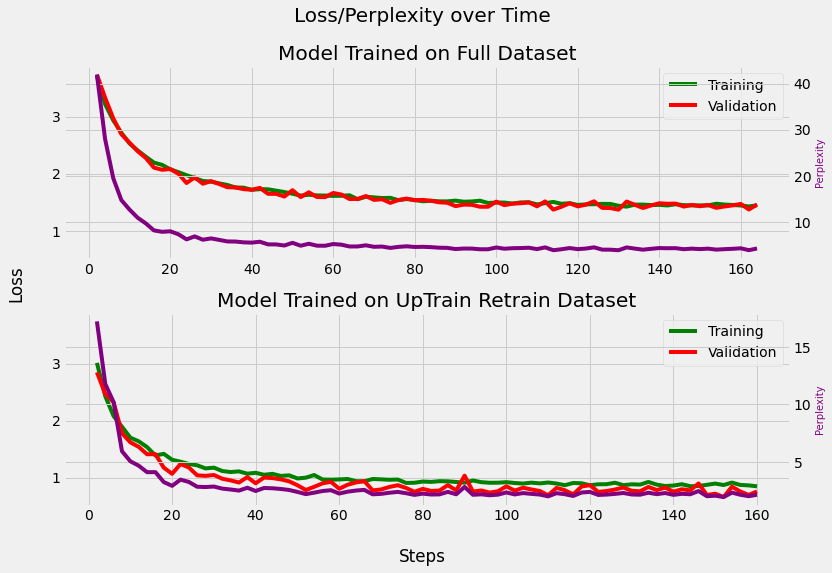

In [20]:
with plt.style.context('fivethirtyeight'):
  fig, axs = plt.subplots(2, 1, sharey = True)

  fig.set_size_inches(12, 8)
  fig.suptitle('Loss/Perplexity over Time', fontsize = 20)
  fig.supxlabel('Steps')
  fig.supylabel('Loss')

  axs[0].set_title('Model Trained on Full Dataset')
  axs[1].set_title('Model Trained on UpTrain Retrain Dataset')

  training_color = 'green'
  validation_color = 'red'
  axs[0].plot(*v1_training_history, label = 'Training', color = training_color)
  axs[0].plot(*v1_eval_history, label = 'Validation', color = validation_color)
  axs[1].plot(*v2_training_history, label = 'Training', color = training_color)
  axs[1].plot(*v2_eval_history, label = 'Validation', color = validation_color)

  color = 'purple'
  axs0twin = axs[0].twinx()
  axs0twin.set_ylabel('Perplexity', fontsize = 10, color = color)
  axs0twin.plot(v1_eval_history[0], v1_perplexities, label = 'Perplexity', color = color)
  axs0twin.tick_params(axis='y', color = color)

  axs1twin = axs[1].twinx()
  axs1twin.set_ylabel('Perplexity', fontsize = 10, color = color)
  axs1twin.plot(v2_eval_history[0], v2_perplexities, label = 'Perplexity', color = color)
  axs1twin.tick_params(axis='y', color = color)

  axs[0].legend()
  axs[1].legend()

  fig.subplots_adjust(top=1)
  fig.tight_layout()

  plt.savefig('loss_perplexity_over_time.png')
  plt.show()

In [21]:
token_scores_v1 = []
token_scores_v2 = []

model, tokenizer = get_model_and_tokenizer(model_save_file_name + '-v1')
model.to('cpu')
unmasker = pipeline('fill-mask', model = model, tokenizer = tokenizer, top_k = 1000)

for text in TESTING_TEXT:
  values = unmasker(text)
  token_scores_v1.append(values[:10] + values[-10:])

model, tokenizer = get_model_and_tokenizer(model_save_file_name + '-v2')
model.to('cpu')
unmasker = pipeline('fill-mask', model = model, tokenizer = tokenizer, top_k = 1000)

for text in TESTING_TEXT:
  values = unmasker(text)
  token_scores_v2.append(values[:10] + values[-10:])

Is "cuda" available? True
Device: Tesla T4
Is "cuda" available? True
Device: Tesla T4


In [22]:
test_text_index = 0 #@param {type:"slider", min:0, max:4, step:1}


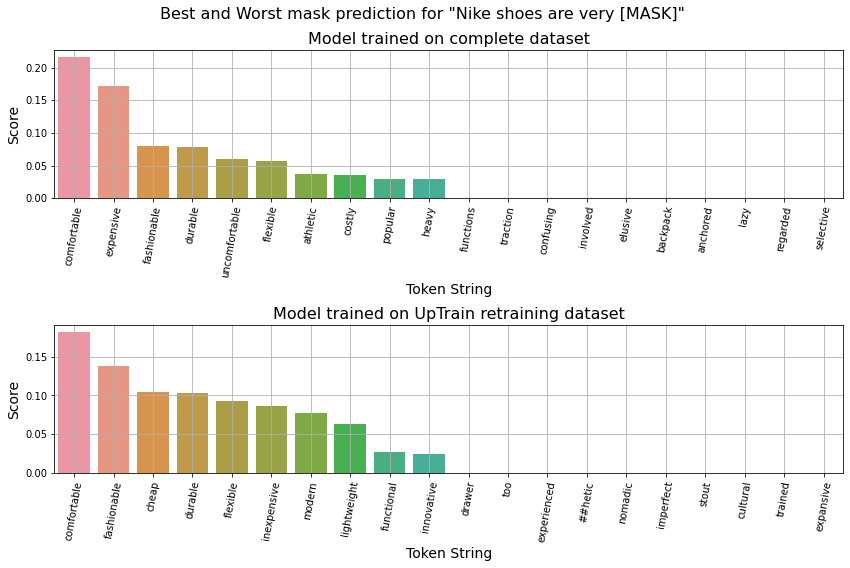

In [23]:
def make_mask_prediction_plot (test_text_index):
    df1 = pd.DataFrame(token_scores_v1[test_text_index])
    df2 = pd.DataFrame(token_scores_v2[test_text_index])

    plt.figure(figsize = (12, 8))
    plt.suptitle(f'Best and Worst mask prediction for "{TESTING_TEXT[test_text_index]}"', fontsize = 16)

    plt.subplot(2, 1, 1)
    ax = sns.barplot(data = df1, x = 'token_str', y = 'score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, ha = 'center')
    ax.grid(True)
    ax.set_xlabel('Token String', fontsize = 14)
    ax.set_ylabel('Score', fontsize = 14)
    ax.set_title('Model trained on complete dataset', fontsize = 16)

    plt.subplot(2, 1, 2)
    ax = sns.barplot(data = df2, x = 'token_str', y = 'score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, ha = 'center')
    ax.grid(True)
    ax.set_xlabel('Token String', fontsize = 14)
    ax.set_ylabel('Score', fontsize = 14)
    ax.set_title('Model trained on UpTrain retraining dataset', fontsize = 16)

    plt.tight_layout()
    # plt.savefig(TESTING_TEXT[test_text_index].replace(' ', '-').replace('[', '').replace(']', '').lower() + '.png')
    plt.show()

make_mask_prediction_plot(test_text_index)

#### All the plots at once

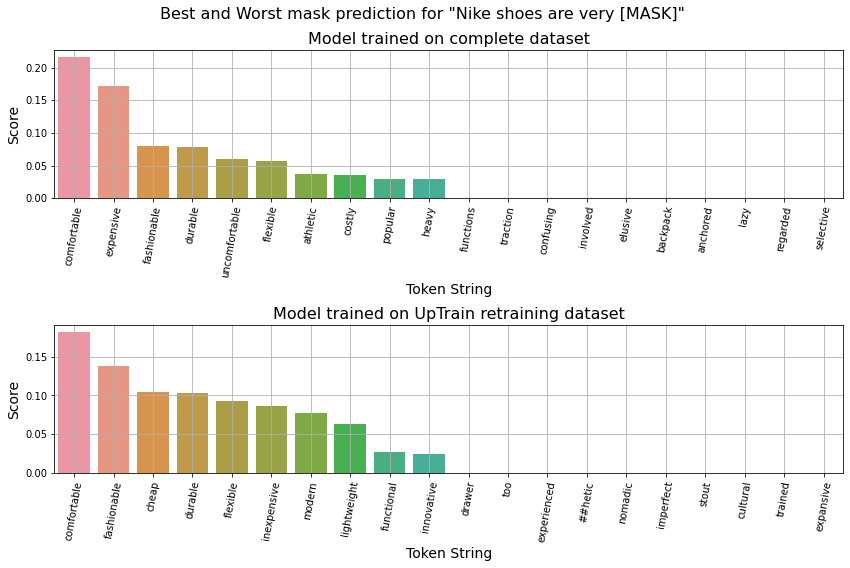

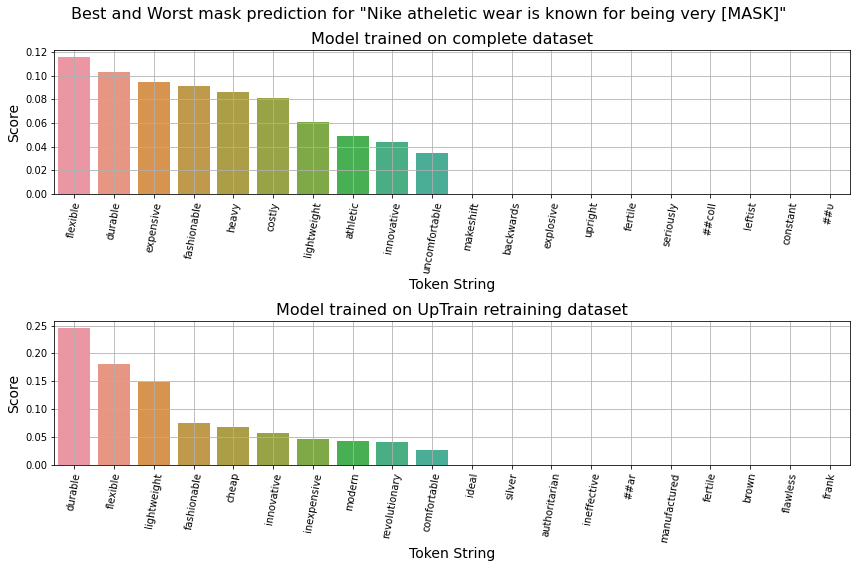

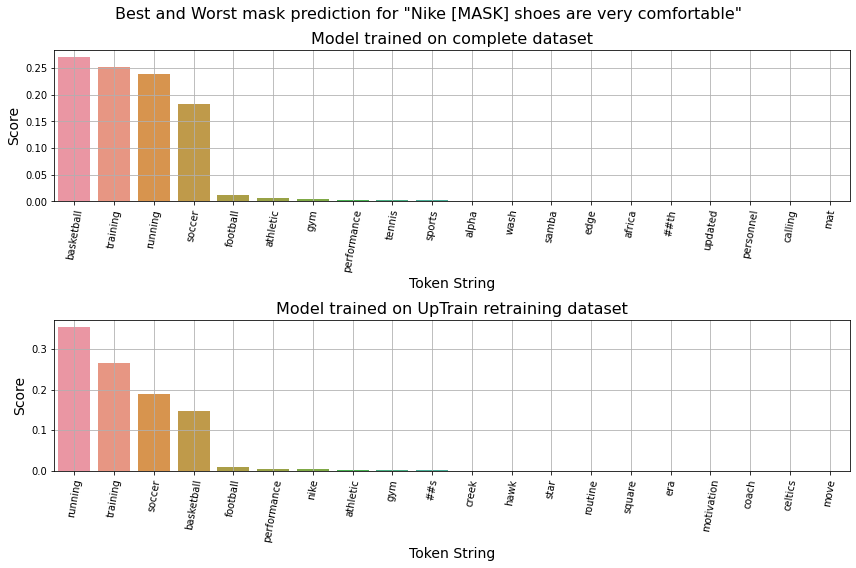

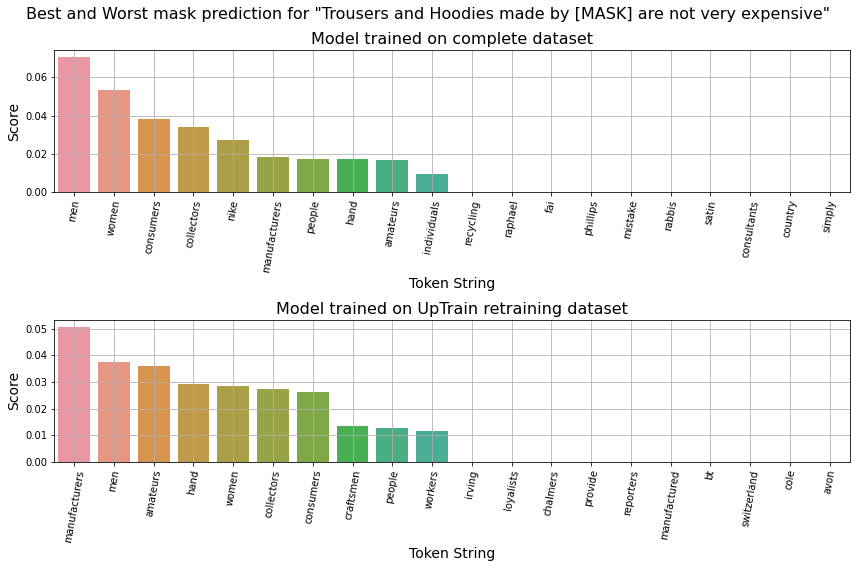

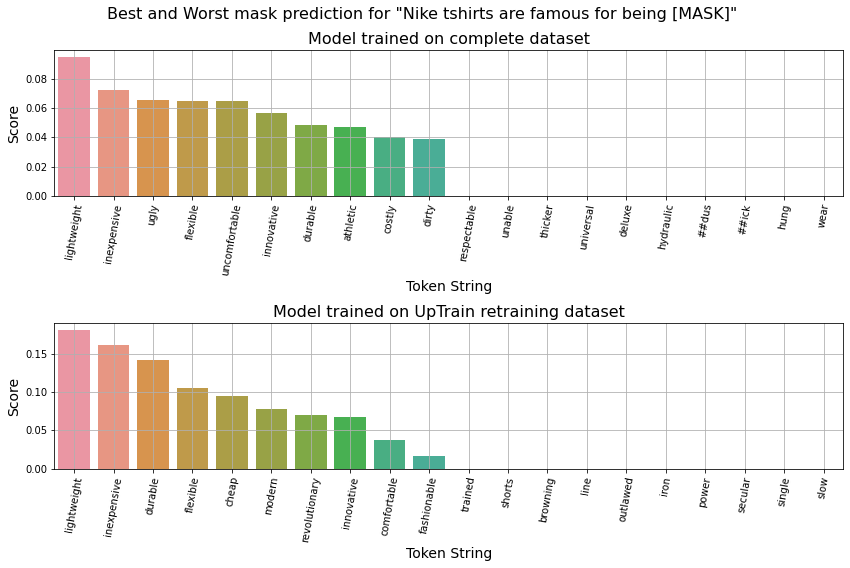

In [24]:
for index in range(len(TESTING_TEXT)):
    make_mask_prediction_plot(index)
    print('\n')

#### Model Accuracy, F1 Score, Confusion Matrix

In [10]:
retrain_dataset = load_dataset('json', data_files={"train": 'data.json'}, field='data')
tokenized_datasets = retrain_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)

lm_datasets = tokenized_datasets.map(group_texts, batched=True)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mlm_probability)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
from datasets import load_metric

def get_accuracy (model, tokenizer):
    metric = load_metric("accuracy")

    def compute_metrics (eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        indices = [[i for i, x in enumerate(labels[row]) if x != -100] for row in range(len(labels))]

        labels = [labels[row][indices[row]] for row in range(len(labels))]
        labels = [item for sublist in labels for item in sublist]

        predictions = [predictions[row][indices[row]] for row in range(len(predictions))]
        predictions = [item for sublist in predictions for item in sublist]

        results = metric.compute(predictions=predictions, references=labels)
        results["eval_accuracy"] = results["accuracy"]
        print(results)
        results.pop("accuracy")

        return results

    training_args = TrainingArguments(
        output_dir=f"hi-finetuned-uptrain",
        overwrite_output_dir=True,
        logging_strategy="steps",
        evaluation_strategy="steps",
        learning_rate=2e-5,
        weight_decay=0.01,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_steps=10,
        eval_steps=2,
        save_steps=10,
        num_train_epochs=1
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=downsampled_dataset["train"],
        eval_dataset=downsampled_dataset["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    training_outputs = CustomCallback(trainer)
    trainer.add_callback(training_outputs)

    return trainer.evaluate()

### Ignore

In [ ]:
!mkdir /content/drive/MyDrive/uptrain
!ls

data.csv
data.json
datasets
distilbert-base-uncased-finetuned-customer-product-support-v1
distilbert-base-uncased-finetuned-customer-product-support-v2
distilbert-base-uncased-finetuned-uptrain
drive
retrain_dataset.json
sample_data
trainer_v1.pickle
trainer_v2.pickle
uptrain_smart_data_bert


In [ ]:
!cp -r data.csv distilbert-base-uncased-finetuned-uptrain distilbert-base-uncased-finetuned-customer-product-support-v1 distilbert-base-uncased-finetuned-customer-product-support-v2 uptrain_smart_data_bert data.json datasets retrain_dataset.json trainer_v1.pickle trainer_v2.pickle /content/drive/MyDrive/uptrain

In [ ]:
!cp *.png /content/drive/MyDrive/uptrain

In [ ]:
# https://huggingface.co/course/chapter7/3

# retrain_dataset = load_dataset('json', data_files={"train": synthesized_data_file_name}, field='data')
# tokenized_datasets = retrain_dataset.map(
#   tokenize_function, batched=True, remove_columns=["text", "label"]
# )

# lm_datasets = tokenized_datasets.map(group_texts, batched=True)
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mlm_probability)

# downsampled_dataset = lm_datasets["train"].train_test_split(
#   train_size=train_size, test_size=test_size,# seed=42
# )

# # Show the training loss with every epoch
# logging_steps = len(downsampled_dataset["train"]) // batch_size

# def insert_random_mask(batch):
#   features = [dict(zip(batch, t)) for t in zip(*batch.values())]
#   masked_inputs = data_collator(features)
#   return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

# downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
# eval_dataset = downsampled_dataset["test"].map(
#     insert_random_mask,
#     batched=True,
#     remove_columns=downsampled_dataset["test"].column_names,
# )
# eval_dataset = eval_dataset.rename_columns(
#   {
#     "masked_input_ids": "input_ids",
#     "masked_attention_mask": "attention_mask",
#     "masked_labels": "labels",
#   }
# )

# train_dataloader = DataLoader(
#   downsampled_dataset["train"],
#   shuffle=True,
#   batch_size=batch_size,
#   collate_fn=data_collator,
# )
# eval_dataloader = DataLoader(
#   eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
# )

# optimizer = AdamW(model.parameters(), lr=5e-5)

# accelerator = Accelerator()
# model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
#   model, optimizer, train_dataloader, eval_dataloader
# )

# num_train_epochs = 5
# num_update_steps_per_epoch = len(train_dataloader)
# num_training_steps = num_train_epochs * num_update_steps_per_epoch

# lr_scheduler = get_scheduler(
#   "linear",
#   optimizer=optimizer,
#   num_warmup_steps=0,
#   num_training_steps=num_training_steps,
# )

# progress_bar = tqdm(range(num_training_steps))

# for epoch in range(num_train_epochs):
#     # Training
#     model.train()
#     for batch in train_dataloader:
#         outputs = model(**batch)
#         loss = outputs.loss
#         accelerator.backward(loss)

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     # Evaluation
#     model.eval()
#     losses = []
#     for step, batch in enumerate(eval_dataloader):
#         with torch.no_grad():
#             outputs = model(**batch)

#         loss = outputs.loss
#         losses.append(accelerator.gather(loss.repeat(batch_size)))

#     losses = torch.cat(losses)
#     losses = losses[: len(eval_dataset)]
#     try:
#         perplexity = math.exp(torch.mean(losses))
#     except OverflowError:
#         perplexity = float("inf")

#     print(f">>> Epoch {epoch}, Perplexity: {perplexity}")

#     accelerator.wait_for_everyone()
#     unwrapped_model = accelerator.unwrap_model(model)
#     unwrapped_model.save_pretrained(uptrain_save_fold_name, save_function=accelerator.save)
#     if accelerator.is_main_process:
#         tokenizer.save_pretrained(uptrain_save_fold_name)

In [ ]:
# for index, sample in enumerate(all_data['data']):
#   if index % 250 == 0:
#     print(f'Sample: {index}')
#   inputs = {'data': {'text': [sample['text']]}}
#   framework.log(inputs = inputs, outputs = None)

# retraining_csv = uptrain_save_fold_name + '/1/smart_data.csv'
# retraining_json = 'retrain_dataset.json'
# csv2json(retraining_csv, retraining_json)

In [ ]:
# retrain_model(model, retraining_dataset)
# retrained_model_outputs = test_model(model, testing_text)